## Comparing Simulation FC of S_E for different delay and Laplacian combinations

What is being modeled:
* Created a Sphere'd Cube (chosen points on cube projected onto radius = 1 sphere), so that regions were more evently distributed. All corners of cube chosen as regions, thus there are 8 regions. 
* EEG channels located on the center of each face of the cube. Thus there are 6 EEG channels.
* Added some randomness to initial values - to decorrelate the signals a bit. Looking for FC matrix to look similar to SC matrix.


In [1]:
from whobpyt.models import RNNJANSEN,ParamsJR,RNNWWD,RWW_Layer,RWW_Params,BOLD_Layer,BOLD_Params,EEG_Layer,EEG_Params,Jansen_Layer

from whobpyt.objective import meanVariableLoss,powerSpectrumLoss,functionalConnectivityLoss

from whobpyt.fit import Model_fitting

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#############################################
## Defining Model Parameters
#############################################

num_regions = 8
num_channels = 6

# Simulation Length
step_size = 0.1 # Step Size in msecs
sim_len = 10000 # Simulation length in msecs

skip_trans = int(2000/step_size)

# Initial Conditions
S_E = 0.20; S_I = 0.05; x = 0.0000; f = 2.4286; v = 1.3283; q = 0.6144 # x,f,v,q might be choosen for different initial S_E
init_state = torch.tensor([[S_E, S_I, x, f, v, q]]).repeat(num_regions, 1)

# Add randomness
init_state = init_state + torch.randn_like(init_state)/30 # Randomizing initial values

# Create a RWW Params
paramsNode = RWW_Params(num_regions)
paramsNode.J = 1.00

#Create #EEG Params
paramsEEG = EEG_Params(torch.eye(num_regions))

#Create BOLD Params
paramsBOLD = BOLD_Params()

In [4]:
#############################################
## Generating a physically possible (in 3D Space) Structural Connectivity Matrix
#############################################

# First, get corner points on a cube and project onto a sphere
square_points = torch.tensor([[1.,1.,1.],
                              [-1.,1.,1.],
                              [1.,-1.,1.],
                              [-1.,-1.,1.],
                              [1.,1.,-1.],
                              [-1.,1.,-1.],
                              [1.,-1.,-1.],
                              [-1.,-1.,-1.]])
sphere_points = square_points / torch.sqrt(torch.sum(torch.square(square_points), axis = 1)).repeat(3, 1).t()

# Second, find the distance between all pairs of points
dist_mtx = torch.zeros(num_regions, num_regions)
for x in range(num_regions):
    for y in range(num_regions):
        dist_mtx[x,y]= torch.linalg.norm(sphere_points[x,:] - sphere_points[y,:])

# Third, Structural Connectivity defined to be 1/dist and remove self-connection values
SC_mtx = 1/dist_mtx
for z in range(num_regions):
    SC_mtx[z,z] = 0.0

# Fourth, Normalize the matrix
SC_mtx_norm = (1/torch.linalg.matrix_norm(SC_mtx, ord = 2)) * SC_mtx
Con_Mtx = SC_mtx_norm

dist_mtx_scaled = dist_mtx / 21 # So that nodes are < 0.1 meters apart

tensor(1.0000)


Text(0.5, 1.0, 'SC of Artificial Data')

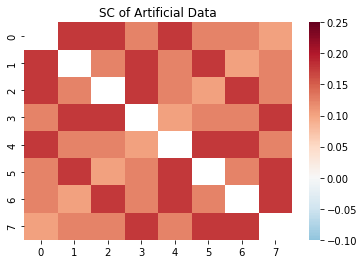

In [5]:
print(max(abs(torch.linalg.eig(SC_mtx_norm).eigenvalues)))
mask = np.eye(num_regions)
sns.heatmap(Con_Mtx, mask = mask, center=0, cmap='RdBu_r', vmin=-0.1, vmax = 0.25)
plt.title("SC of Artificial Data")

tensor(0.4935)
tensor([[0.0000, 0.0550, 0.0550, 0.0778, 0.0550, 0.0778, 0.0778, 0.0952],
        [0.0550, 0.0000, 0.0778, 0.0550, 0.0778, 0.0550, 0.0952, 0.0778],
        [0.0550, 0.0778, 0.0000, 0.0550, 0.0778, 0.0952, 0.0550, 0.0778],
        [0.0778, 0.0550, 0.0550, 0.0000, 0.0952, 0.0778, 0.0778, 0.0550],
        [0.0550, 0.0778, 0.0778, 0.0952, 0.0000, 0.0550, 0.0550, 0.0778],
        [0.0778, 0.0550, 0.0952, 0.0778, 0.0550, 0.0000, 0.0778, 0.0550],
        [0.0778, 0.0952, 0.0550, 0.0778, 0.0550, 0.0778, 0.0000, 0.0550],
        [0.0952, 0.0778, 0.0778, 0.0550, 0.0778, 0.0550, 0.0550, 0.0000]])


Text(0.5, 1.0, 'Distance Matrix of Artificial Data')

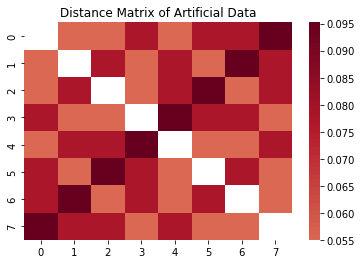

In [6]:
print(max(abs(torch.linalg.eig(dist_mtx_scaled).eigenvalues)))
print(dist_mtx_scaled)
mask = np.eye(num_regions)
sns.heatmap(dist_mtx_scaled, mask = mask, center=0, cmap='RdBu_r')
plt.title("Distance Matrix of Artificial Data")

In [7]:
#############################################
## Generating a Lead Field Matrix
#############################################

# Placing an EEG Electrode in the middle of each cube face. 
# Then electrode is equally distance from four courner on cube face squre.
# Assume no signal from further four points. 

Lead_Field = torch.tensor([[1,1,0,0,1,1,0,0],
                           [1,1,1,1,0,0,0,0],
                           [0,1,0,1,0,1,0,1],
                           [0,0,0,0,1,1,1,1],
                           [1,0,1,0,1,0,1,0],
                           [0,0,1,1,0,0,1,1]], dtype = torch.float)
LF_Norm = (1/torch.linalg.matrix_norm(Lead_Field, ord = 2)) * Lead_Field

paramsEEG.LF = LF_Norm

In [8]:
#############################################
## Generating a "Connectivity Matrix" for Channel Space
#############################################

## Generating a physically possible (in 3D Space) "Channel" Connectivity Matrix
# That is a theoretical matrix for the EEG SC to be fit to

# First, get face points on a cube and project onto a sphere
LF_square_points = torch.tensor([[0.,1.,0.],
                                 [0.,0.,1.],
                                 [-1.,0.,0.],
                                 [0.,0.,-1.],
                                 [1.,0.,0.],
                                 [0.,-1.,0.]])
# Note: this does nothing as the points are already on the r=1 sphere
LF_sphere_points = LF_square_points / torch.sqrt(torch.sum(torch.square(LF_square_points), axis = 1)).repeat(3, 1).t()


# Second, find the distance between all pairs of channel points
LF_dist_mtx = torch.zeros(num_channels, num_channels)
for x in range(num_channels):
    for y in range(num_channels):
        LF_dist_mtx[x,y]= torch.linalg.norm(LF_sphere_points[x,:] - LF_sphere_points[y,:])

# Third, Structural Connectivity defined to be 1/dist and remove self-connection values
LF_SC_mtx = 1/LF_dist_mtx
for z in range(num_channels):
    LF_SC_mtx[z,z] = 0.0

# Fourth, Normalize the matrix
LF_SC_mtx_norm = (1/torch.linalg.matrix_norm(LF_SC_mtx, ord = 2)) * LF_SC_mtx
LF_Con_Mtx = LF_SC_mtx_norm

## Defining the CNMM Model

In [9]:
## The Multi-Modal Model

class mmModel(torch.nn.Module):
    def __init__(self):
        super(mmModel, self).__init__()
        
        self.nodes = RWW_Layer(num_regions, paramsNode, Con_Mtx, dist_mtx_scaled, step_size)
        self.eeg = EEG_Layer(num_regions, paramsEEG, num_channels)
        self.bold = BOLD_Layer(num_regions, paramsBOLD)
        
        self.next_start_state = init_state
        
    def forward(self, debug = False, useDelays = False, useLaplacian = False):
        
        self.step_size = step_size #in msec
        self.sim_len = sim_len #in msec
        
        node_states, node_history = self.nodes.forward(self.next_start_state[:, 0:2], self.sim_len, useDelays = useDelays, useLaplacian = useLaplacian, debug = debug)
        EEG_history = self.eeg.forward(self.step_size, self.sim_len, node_history)
        BOLD_states, BOLD_history = self.bold.forward(self.next_start_state[:, 2:6], self.step_size, self.sim_len, node_history[:,:,0])

        self.next_start_state = torch.cat((node_states, BOLD_states), dim=1).detach()
        
        return node_history, EEG_history, BOLD_history
        

## Running The Model

In [10]:
model = mmModel()
node_history1, EEG_history1, BOLD_history1 = model.forward(useDelays = False, useLaplacian = False)
model = mmModel()
node_history2, EEG_history2, BOLD_history2 = model.forward(useDelays = True, useLaplacian = False)
model = mmModel()
node_history3, EEG_history3, BOLD_history3 = model.forward(useDelays = False, useLaplacian = True)
model = mmModel()
node_history4, EEG_history4, BOLD_history4 = model.forward(useDelays = True, useLaplacian = True)


### Plots of S_E FC

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: Original'}>

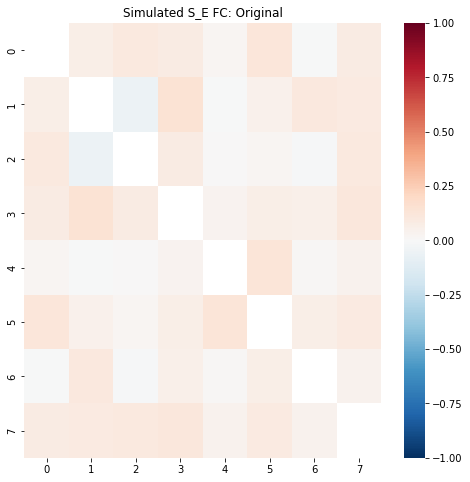

In [11]:
print(node_history1[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history1[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: Original")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: With Delay'}>

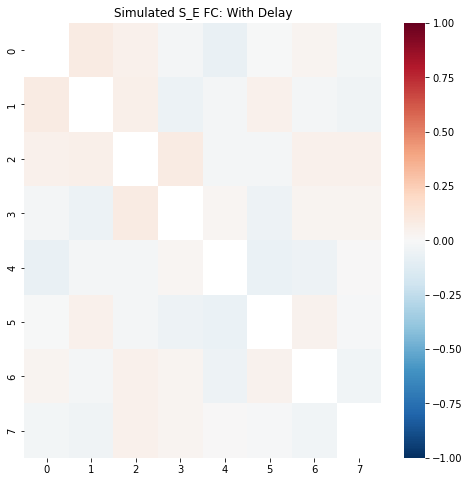

In [12]:
print(node_history2[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history2[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: With Delay")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: With Laplacian'}>

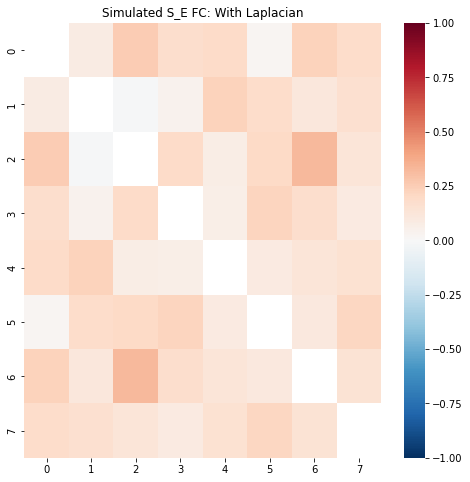

In [13]:
print(node_history3[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history3[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: With Laplacian")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: With Delay and Laplacian'}>

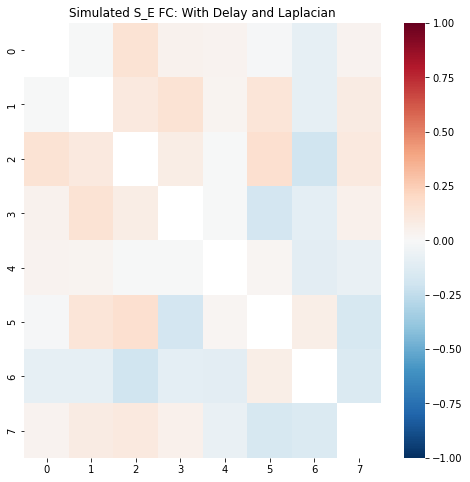

In [14]:
print(node_history4[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history4[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: With Delay and Laplacian")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

## Increasing G

In [15]:
paramsNode.G = 10

In [16]:
model = mmModel()
node_history1, EEG_history1, BOLD_history1 = model.forward(useDelays = False, useLaplacian = False)
model = mmModel()
node_history2, EEG_history2, BOLD_history2 = model.forward(useDelays = True, useLaplacian = False)
model = mmModel()
node_history3, EEG_history3, BOLD_history3 = model.forward(useDelays = False, useLaplacian = True)
model = mmModel()
node_history4, EEG_history4, BOLD_history4 = model.forward(useDelays = True, useLaplacian = True)

### Plots of S_E FC

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: Original'}>

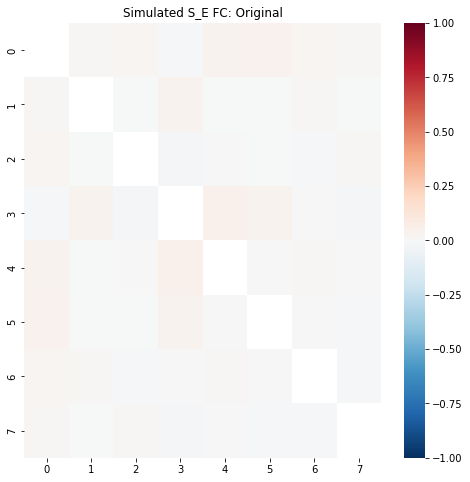

In [17]:
print(node_history1[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history1[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: Original")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: With Delay'}>

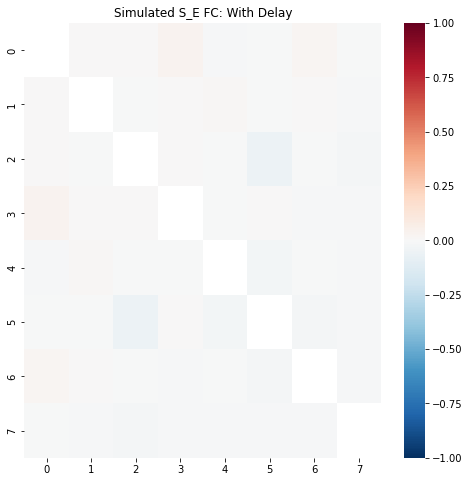

In [18]:
print(node_history2[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history2[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: With Delay")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: With Laplacian'}>

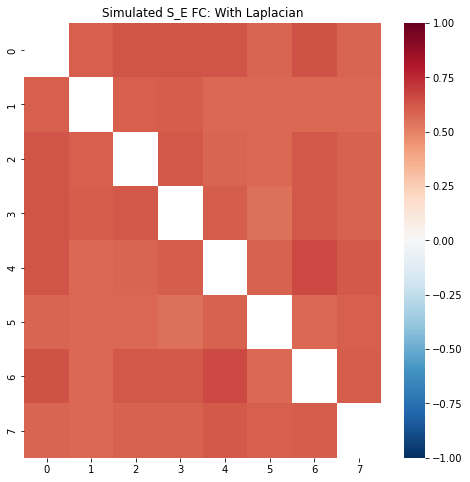

In [19]:
print(node_history3[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history3[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: With Laplacian")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: With Delay and Laplacian'}>

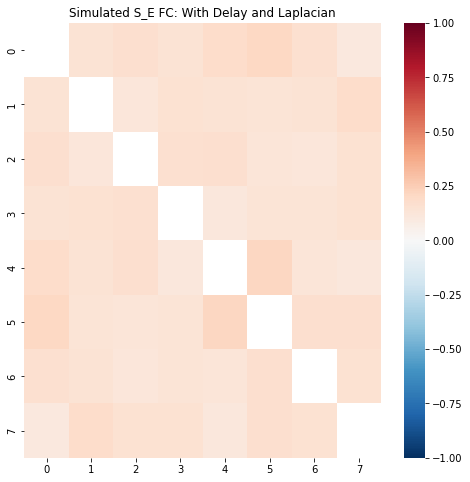

In [20]:
print(node_history4[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history4[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: With Delay and Laplacian")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

## Increasing G further, and Increasing Noise, to force out SC in the FC

In [21]:
paramsNode.G = 20
paramsNode.sig = 0.2

In [22]:
model = mmModel()
node_history1, EEG_history1, BOLD_history1 = model.forward(useDelays = False, useLaplacian = False)
model = mmModel()
node_history2, EEG_history2, BOLD_history2 = model.forward(useDelays = True, useLaplacian = False)
model = mmModel()
node_history3, EEG_history3, BOLD_history3 = model.forward(useDelays = False, useLaplacian = True)
model = mmModel()
node_history4, EEG_history4, BOLD_history4 = model.forward(useDelays = True, useLaplacian = True)

### Plots of S_E FC

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: Original'}>

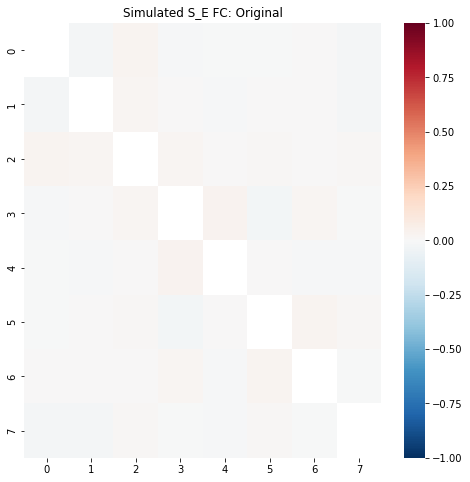

In [23]:
print(node_history1[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history1[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: Original")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: With Delay'}>

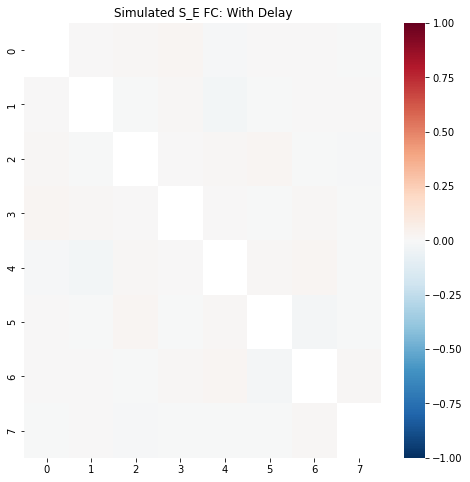

In [24]:
print(node_history2[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history2[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: With Delay")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: With Laplacian'}>

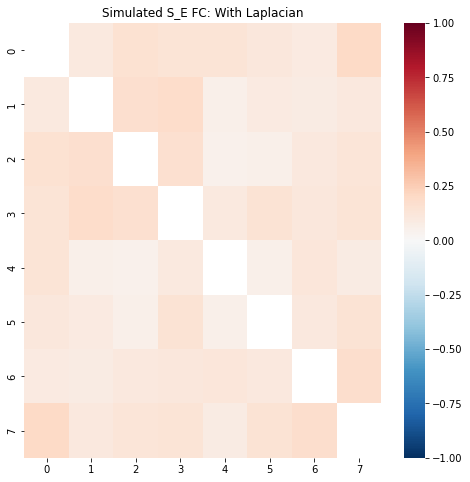

In [25]:
print(node_history3[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history3[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: With Laplacian")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)

torch.Size([80000, 8])


<AxesSubplot:title={'center':'Simulated S_E FC: With Delay and Laplacian'}>

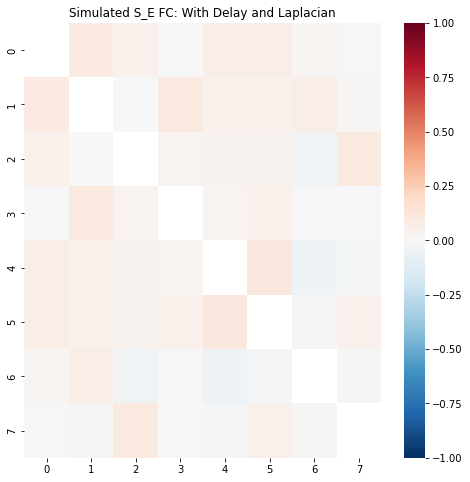

In [26]:
print(node_history4[skip_trans:, :, 0].shape)
sim_FC = functionalConnectivityLoss.calcFC(node_history4[skip_trans:, :, 0]).detach()

plt.figure(figsize = (8, 8))
plt.title("Simulated S_E FC: With Delay and Laplacian")
mask = np.eye(num_regions)
sns.heatmap(sim_FC, mask = mask, center=0, cmap='RdBu_r', vmin=-1.0, vmax = 1.0)